In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys
import numpy as np
import pandas as ps

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset 


from l5kit.geometry import transform_points
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv
from l5kit.visualization import draw_trajectory

sys.path.append("..")

import matplotlib.pyplot as plt

%matplotlib inline

from src.batteries import t2d, load_checkpoint
from src.batteries.progress import tqdm
from src.models.genet import genet_normal
from src.models.resnets import resnet18
from src.models import ModelWithConfidence
from src.criterion import neg_multi_log_likelihood_batch

In [3]:
DATA_DIR = "../data"
os.environ["L5KIT_DATA_FOLDER"] = DATA_DIR

In [4]:
cfg = {
    "format_version": 4,
    "model_params": {
        "history_num_frames": 10,
        "history_step_size": 1,
        "history_delta_time": 0.1,
        "future_num_frames": 50,
        "future_step_size": 1,
        "future_delta_time": 0.1,
    },
    "raster_params": {
        "raster_size": [384, 384],
        "pixel_size": [0.5, 0.5],
        "ego_center": [0.25, 0.5],
        "map_type": "py_semantic",
        "satellite_map_key": "aerial_map/aerial_map.png",
        "semantic_map_key": "semantic_map/semantic_map.pb",
        "dataset_meta_key": "meta.json",
        "filter_agents_threshold": 0.5,
    },
    "train_data_loader": {
        "key": "scenes/train.zarr",
        "batch_size": 12,
        "shuffle": True,
        "num_workers": 4,
    },
}

history_n_frames = cfg["model_params"]["history_num_frames"]
future_n_frames = cfg["model_params"]["future_num_frames"]
n_trajectories = 3
# model = ModelWithConfidence(
#     backbone=genet_normal(
#         in_channels=3 + (history_n_frames + 1) * 2,
#         num_classes=2 * future_n_frames * n_trajectories + n_trajectories,
#     ),
#     future_num_frames=future_n_frames,
#     num_trajectories=n_trajectories,
# )
model = ModelWithConfidence(
    backbone=resnet18(
        pretrained=False,
        in_channels=3 + 2 * (history_n_frames + 1),
        num_classes=2 * future_n_frames * n_trajectories + n_trajectories,
    ),
    future_num_frames=future_n_frames,
    num_trajectories=n_trajectories,
)
load_checkpoint("../logs/resnet18_bigerimages/stage_0/best.pth", model)

<= Loaded model from '../logs/resnet18_bigerimages/stage_0/best.pth'
Stage: stage_0
Epoch: 1
Metrics:
{'train': {'loss': 16.331650656055654}, 'valid': {'loss': 16.331650656055654}}


In [5]:
model = model.eval()

In [6]:
dm = LocalDataManager(None)
rasterizer = build_rasterizer(cfg, dm)

valid_zarr = ChunkedDataset(dm.require("scenes/validate_chopped_100/validate.zarr")).open()
# test_mask = np.load(f"{DATA_DIR}/scenes/mask.npz")["arr_0"]

valid_dataset = AgentDataset(
    cfg, valid_zarr, rasterizer
)

In [83]:
TARGET_POINTS_COLOR = (255, 0, 0)
HISTORICAL_POINTS_COLOR = (255, 255, 0)
PREDICT_POINTS_COLOR = (128, 0, 128)


def visualize_trajectory(
    data, show=True, title="target_positions movement with draw_trajectory"
):
    with torch.no_grad():
        preds, conf = model(torch.from_numpy(data["image"]).unsqueeze(0))

    preds = preds.detach().cpu().numpy()[0]
    
    for mode in range(3):
        preds[mode, :, :] = transform_points(preds[mode, :, :], data["raster_from_agent"]) # - data["centroid"][:2]
    
    plt.figure(figsize=(13, 13))
    im = data["image"].transpose(1, 2, 0)
    im = rasterizer.to_rgb(im)

    positions_tgt = transform_points(
        data["target_positions"],
        data["raster_from_agent"]
    )
    draw_trajectory(
        on_image=im,
        positions=positions_tgt,
        rgb_color=TARGET_POINTS_COLOR,
        radius=1
    )
    
    for mode in range(3):
        draw_trajectory(
            on_image=im,
            positions=preds[mode],
            rgb_color=PREDICT_POINTS_COLOR,
            radius=1
        )
    
    positions_hst = transform_points(
        data["history_positions"],
        data["raster_from_agent"]
    )
    draw_trajectory(
        on_image=im,
        positions=positions_hst,
        rgb_color=HISTORICAL_POINTS_COLOR,
        radius=2
    )

    if show:
        plt.title(title)
        plt.imshow(im[::-1])
        plt.show()
    else:
        return im[::-1]

In [95]:
losses = ps.read_csv("findings/validation_subset_losses.csv")
# losses = losses.sort_values("loss", ascending=False)
losses = losses.sort_values("loss", ascending=True)

print(losses.shape)
start, size = 100, 20
losses.iloc[start:start + size]

(592216, 2)


,record,loss
449471,449471,0.000011
324575,324575,0.000011
50310,50310,0.000011
176058,176058,0.000011
238312,238312,0.000011
371432,371432,0.000011
445147,445147,0.000011
557750,557750,0.000011
563151,563151,0.000011
535094,535094,0.000011


In [13]:
# with torch.no_grad():
#     preds, conf = model(torch.from_numpy(sample["image"]).unsqueeze(0))

# preds = preds.detach().cpu().numpy()[0]
# preds.shape

In [14]:
# preds[0]

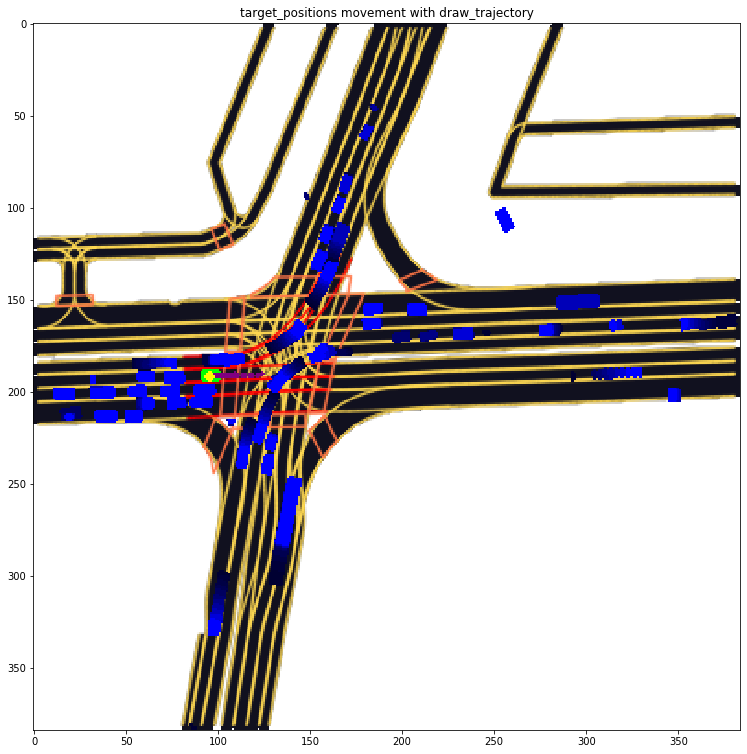

In [100]:
idx = 74607
sample = valid_dataset[idx]
visualize_trajectory(sample)

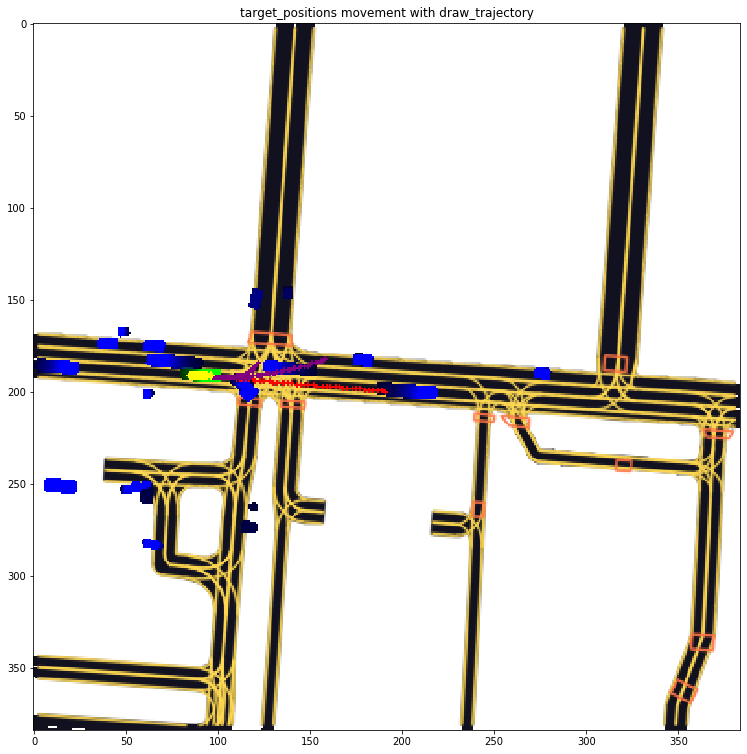

In [79]:
idx = 56748
sample = valid_dataset[idx]

# columns = 11
# rows = 3

# fig = plt.figure(figsize=(80, 20), facecolor="white")

# for i in range(11):
#     fig.add_subplot(rows, columns, i + 1)
#     plt.imshow(sample["image"][i])
#     plt.title(f"frame {i}")
    
# for i in range(11, 22):
#     fig.add_subplot(rows, columns, i + 1)
#     plt.imshow(sample["image"][i])
#     plt.title(f"frame {i - 11}")
    
# for i in range(22, 25):
#     fig.add_subplot(rows, columns, i + 1)
#     plt.imshow(sample["image"][i])

visualize_trajectory(sample)